[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/exercises/Ex05-NN-in-Keras.ipynb)



# Neural Networks using Keras



### Outline
Our goal is to tune the Apple Store NN for multi-class classification. We need to make several decisions when configuring our NN and focus on finding the optimal parameters for the
 - number of hidden layers
 - number of neurons in hidden layers
 - activation functions
 - type of weight initialization
 - learning rate and momentum
 - optimizer
 - size of batch
 - number of epochs
 - regularization (dropout)



In a first Part of this Notebook we will use Grid Search for Hyperparameter Tuning.

Then in a second Part we will use Keras-Tuner

In [ ]:
# Setting up the environment: import standard libraries and load the data.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#This package provides utilities for Keras, such as modified callbacks, data genereators, encoder, etc.

##Use case: app rating analysis
NNs often **solve classification problems with many classes**. To illustrate their functioning in a context that is more related to NLP examples,we introduce the data set concerned with app ratings. The **original data is available on Kaggle**. There, you also find a data dictionary with some information on the variables. However, the variable names are rather self-explanatory. A cleaned version of the data is available in this folder. The easiest way for you is to use the cleaned version but feel very free to play around with the version on Kaggle. You can find a Python script that starts from the original data and goes through a couple of pre-processing operations to produce the version we use below (**app_store_dpp.py**).

In [ ]:
# Load dataset and set app name as index

app = pd.read_csv("https://raw.githubusercontent.com/murpi/wilddata/master/quests/AppleStore_prep.csv",
                  index_col=False, sep='\t', encoding='utf-8')
app = app.set_index('track_name')
app.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7197 entries, PAC-MAN Premium to Escape the Sweet Shop Series
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   size_bytes                     7197 non-null   float64
 1   price                          7197 non-null   float64
 2   rating_count_tot               7197 non-null   float64
 3   sup_devices.num                7197 non-null   float64
 4   ipadSc_urls.num                7197 non-null   float64
 5   lang.num                       7197 non-null   float64
 6   vpp_lic                        7197 non-null   float64
 7   currency_USD                   7197 non-null   int64  
 8   cont_rating_12+                7197 non-null   int64  
 9   cont_rating_17+                7197 non-null   int64  
 10  cont_rating_4+                 7197 non-null   int64  
 11  cont_rating_9+                 7197 non-null   int64  
 12  prime_genre_Boo

So **36 columns**, **one of which is the target variable**. We consider the **user rating as our target** and will try to set up a NN that predict the rating from the app characteristics including information on its price, genre, etc.

Let's have a quick look at the target variable. Note that we that we have reduced the number of rating classes compared to the original version of the data on Kaggle (see app_store_dpp.py for details).  


<Axes: xlabel='user_rating', ylabel='count'>

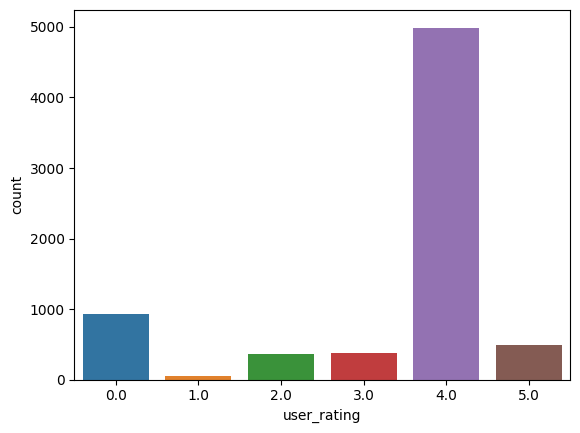

In [ ]:
# Inspect the target
import seaborn as sns
sns.countplot(app, x='user_rating')

In [ ]:
app["user_rating"]

track_name
PAC-MAN Premium                                       4.0
Evernote - stay organized                             4.0
WeatherBug - Local Weather, Radar, Maps, Alerts       4.0
eBay: Best App to Buy, Sell, Save! Online Shopping    4.0
Bible                                                 4.0
                                                     ... 
Kubik                                                 4.0
VR Roller-Coaster                                     4.0
Bret Michaels Emojis + Lyric Keyboard                 4.0
VR Roller Coaster World - Virtual Reality             4.0
Escape the Sweet Shop Series                          5.0
Name: user_rating, Length: 7197, dtype: float64

In [ ]:
# Prepare the target variable
# LabelEncoder() transforms a string vector to a num vector
encoder = LabelEncoder()
#fit label encoder
encoder.fit(app["user_rating"])
#transform and return encoded labels
encoder.transform(app["user_rating"])




array([4, 4, 4, ..., 4, 4, 5])

In [ ]:
from keras.utils import to_categorical

dummy_y = to_categorical( encoder.transform(app["user_rating"])).astype(int)
dummy_y

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])

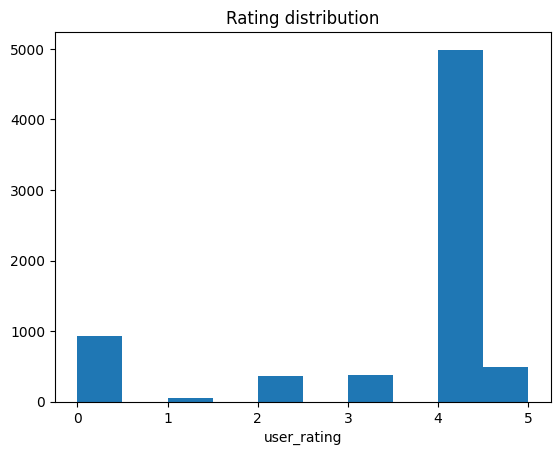

(5037, 35)
(5037, 6)


In [ ]:
plt.hist(dummy_y.argmax(axis=1))
plt.xlabel('user_rating')
plt.title('Rating distribution')
plt.show();

# Let's split our data set

#Seed function is used to save the state of a random function, so that it can generate same random numbers on multiple executions of the code on the same machine or on different machines (for a specific seed value)
seed=42

X = app.iloc[:,:-1].values
y = dummy_y

# Keep in mind that this data set is already standardized, which leads to a leakage of information from train set to test set
# When you are working with a dataset, make sure you standardize the variables in test set according to the parameters of the train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)

print (X_train.shape)
print(y_train.shape)
#X.head(5)

### Preparing the Keras framework ###

Today we will revise the architecture of our basic neural network and look more into the tuning of hyperparameters.



In [ ]:
nb_units = 128
# And finally the outout layer
nb_classes = y.shape[1]

In [ ]:
# Import Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD


model = Sequential()
model.add(Dense(nb_units, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed), input_shape=(X.shape[1],)))
#model.add(Dropout(0.1))
model.add(Dense(nb_units, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))
#model.add(Dropout(0.1))
model.add(Dense(nb_classes, activation='softmax'))

model.summary()

batch_size = 56 #1 for online SGD

# example: start tarining the model up until 30 epochs and plot the training loss values and validation loss values against number of epochs.
epochs = 30


model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])
# Fit the model
story = model.fit(X_train, y_train, #name model differently
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                 validation_data=(X_test, y_test))
                    #validation_split=0.33)#validation_data=(X_test, y_test)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 128)               4608      
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                                 
 dense_32 (Dense)            (None, 6)                 774       
                                                                 
Total params: 21894 (85.52 KB)
Trainable params: 21894 (85.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    ax1.plot(story.history['accuracy'])
    ax1.plot(story.history['val_accuracy'])
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['train_accuracy', 'test_accuracy'], loc='best')
    ax1.set_title('Accuracy evolution during NN training')

    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during NN training')
    plt.show()


In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)

Test loss: 0.955611526966095
Test accuracy: 0.7115740776062012


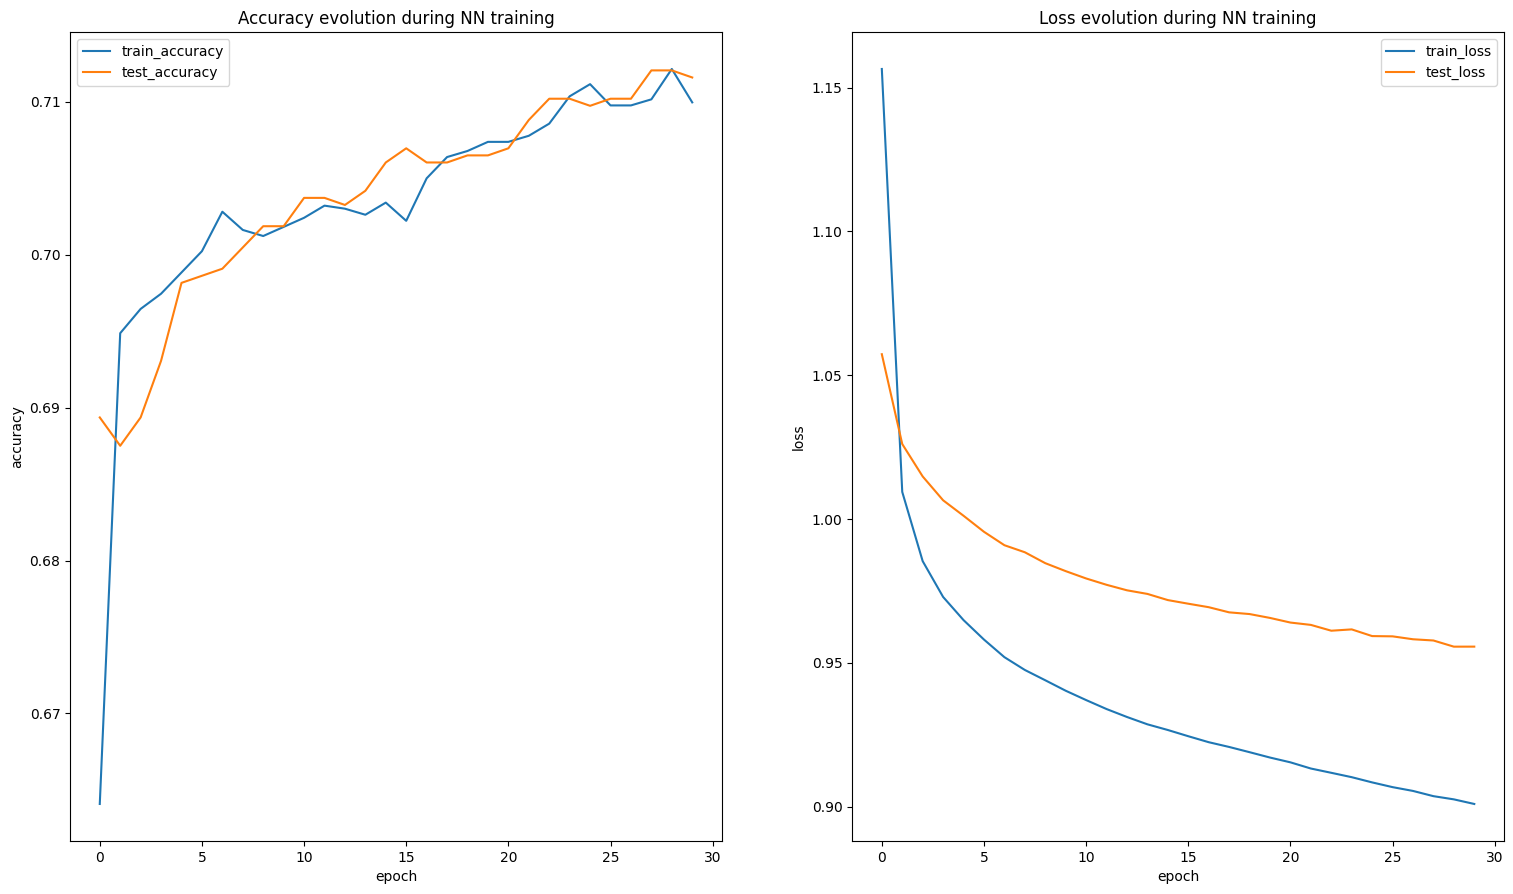

In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])
show_history(story)

# Part 1: Hyperparameter optimization with Keras





We will start with the old-fashioned way with Scikit Learn and will first show you an example of how to use GridSearch with two groups of hyperparameters: batches/epochs and optimizer algorithms.

In [ ]:
!pip install scikeras

In [ ]:
import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from keras import optimizers

In [ ]:
#We will use the architecture we had before and wrap it into the function called 'netowork ' (or whatever you want to call it)

def network():

    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed),  input_shape=(X.shape[1],)))
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))
    model.add(Dense(6, activation='softmax',kernel_initializer=keras.initializers.he_normal(seed=seed)))

    model.compile(optimizer=optimizers.SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy']) #nothing changes here

    return model

# Now we will plug it into Keras Classifier Wrapper
model = KerasClassifier(build_fn=network, verbose=0)

In [ ]:
# Let's define the grid search parameters
batchsize = [32, 64, 128, 256, 512]
epochs = [10,30,60,70]

In [ ]:
#Set the grid
param_grid = dict(batch_size=batchsize, epochs=epochs)# setting a dictionary to store the results
param_grid

{'batch_size': [32, 64, 128, 256, 512], 'epochs': [10, 30, 60, 70]}

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,cv=3) #parallelization, here using all processors
results = grid.fit(X_train, y_train) #remember that we don't want to use the test set in CV
print("Best: %f using %s" % (results.best_score_, results.best_params_))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best: 0.711733 using {'batch_size': 32, 'epochs': 60}


In [ ]:
#Let's now take this knowledge and apply it to our optimizers tuning

def optim (optimizer='SGD'):
    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed),  input_shape=(X.shape[1],)))

    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))

    model.add(Dense(6, activation='softmax',kernel_initializer=keras.initializers.he_normal(seed=seed)))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = KerasClassifier(build_fn=optim, epochs=30, batch_size=64, verbose=0)
# define the grid search parameters
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizers) # setting a dictionary to store the results
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

# Our results (reember these are the resultson the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best: 0.702799 using {'optimizer': 'RMSprop'}


Now continue using Grid Search to tune the Learning Rate and Momentum:

In [ ]:
from tensorflow.keras.optimizers import SGD

param_grid = {
    'optimizer__learning_rate': [0.001, 0.01, 0.1],
    'optimizer__momentum': [0.5, 0.9, 0.99]
}

def build_model():
  model = Sequential()

  model.add(Dense(128, activation='relu', bias_initializer='zeros', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
  model.add(Dense(128, activation='relu', bias_initializer='zeros', kernel_initializer='he_normal'))
  model.add(Dense(6, activation='softmax', kernel_initializer='he_normal'))

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

  return model

model2 = KerasClassifier(build_fn=build_model, epochs=30, batch_size=64, verbose=0, optimizer=SGD)
grid_search = GridSearchCV(estimator=model2, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (results.best_score_, results.best_params_))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best: 0.709549 using {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.99}


Use Grid Search to tune the Network Weight Initialization:

In [ ]:
param_grid = {
    'model__kernel_initializer': ['zeros', 'ones', 'constant', 'random_normal']
}

def build_model_init(kernel_initializer):
  model = Sequential()

  model.add(Dense(128, activation='relu', bias_initializer='zeros', kernel_initializer=kernel_initializer, input_shape=(X_train.shape[1],)))
  model.add(Dense(128, activation='relu', bias_initializer='zeros', kernel_initializer=kernel_initializer))
  model.add(Dense(6, activation='softmax', kernel_initializer=kernel_initializer))

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

  return model


model3 = KerasClassifier(build_fn=build_model_init, epochs=30, batch_size=64, verbose=0)
grid_search = GridSearchCV(estimator=model3, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (results.best_score_, results.best_params_))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best: 0.712329 using {'model__kernel_initializer': 'random_normal'}


Use Grid Search to tune the Neuron Activation Function


In [ ]:
param_grid = {
    'model__activation': ['linear', 'relu', 'sigmoid', 'tanh', 'softmax']
}

def build_model_activation(activation):
  model = Sequential()

  model.add(Dense(128, activation=activation, bias_initializer='zeros', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
  model.add(Dense(128, activation=activation, bias_initializer='zeros', kernel_initializer='he_normal'))
  model.add(Dense(6, activation='softmax', kernel_initializer='he_normal'))

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

  return model


model4 = KerasClassifier(build_fn=build_model_activation, epochs=30, batch_size=64, verbose=0)
grid_search = GridSearchCV(estimator=model4, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (results.best_score_, results.best_params_))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best: 0.704785 using {'model__activation': 'linear'}


Use Grid Search to tune Dropout Regularization

In [ ]:
param_grid = {
    'model__dropout_rate': [0.2, 0.3, 0.4, 0.5]
}

def build_model_dropout(dropout_rate):
  model = Sequential()

  model.add(Dense(128, activation='relu', bias_initializer='zeros', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
  model.add(Dropout(dropout_rate))
  model.add(Dense(128, activation='relu', bias_initializer='zeros', kernel_initializer='he_normal'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(6, activation='softmax', kernel_initializer='he_normal'))

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

  return model


model5 = KerasClassifier(build_fn=build_model_dropout, epochs=30, batch_size=64, verbose=0)
grid_search = GridSearchCV(estimator=model5, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (results.best_score_, results.best_params_))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best: 0.710939 using {'model__dropout_rate': 0.5}


Use Grid Search to tune the Number of Neurons in the Hidden Layer

In [ ]:
param_grid = {
    'model__neurons': [32, 64, 128, 256]
}

def build_model_neurons(neurons):
  model = Sequential()

  model.add(Dense(neurons, activation='relu', bias_initializer='zeros', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
  model.add(Dense(neurons, activation='relu', bias_initializer='zeros', kernel_initializer='he_normal'))
  model.add(Dense(6, activation='softmax', kernel_initializer='he_normal'))

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

  return model


model6 = KerasClassifier(build_fn=build_model_neurons, epochs=30, batch_size=64, verbose=0)
grid_search = GridSearchCV(estimator=model6, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (results.best_score_, results.best_params_))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best: 0.712130 using {'model__neurons': 64}


# Part 2:  Keras Tuner

In [ ]:
! pip install -U keras-tuner

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

Read through the Keras Tuner Documentation and build a RandomSearch. This hyperparameter tuning method randomly tries a combination of hyperparameters from a given search space. To use this method in keras tuner, first define a tuner using one of the available [Tuners](https://keras-team.github.io/keras-tuner/documentation/tuners/).


In [ ]:
def build_model_for_tuner(hp):
  model = Sequential()

  units_hp_1 = hp.Choice('units_1', [32, 64, 128, 256])
  units_hp_2 = hp.Choice('units_2', [32, 64, 128, 256])
  activations = ('linear', 'relu', 'sigmoid', 'tanh', 'softmax')
  activation_hp_1 = hp.Choice('activation_1', activations)
  activation_hp_2 = hp.Choice('activation_2', activations)
  kernel_initializers = ['zeros', 'ones', 'constant', 'random_normal']
  kinitializer_hp_1 = hp.Choice('kernel_init_1', kernel_initializers)
  kinitializer_hp_2 = hp.Choice('kernel_init_2', kernel_initializers)
  kinitializer_hp_3 = hp.Choice('kernel_init_3', kernel_initializers)
  optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
  optimizer_hp = hp.Choice('optimizer', optimizers)

  model.add(Dense(units=units_hp_1, activation=activation_hp_1, bias_initializer='zeros', kernel_initializer=kinitializer_hp_1, input_shape=(X_train.shape[1],)))
  model.add(Dense(units=units_hp_2, activation=activation_hp_2, bias_initializer='zeros', kernel_initializer=kinitializer_hp_2))
  model.add(Dense(6, activation='softmax', kernel_initializer=kinitializer_hp_3))

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer_hp)

  return model

In [ ]:
tuner = RandomSearch(
    build_model_for_tuner,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=4,
    directory='tunnable_models',
    project_name='wow'
)
tuner.search_space_summary()

Search space summary
Default search space size: 8
units_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
units_2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
activation_1 (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu', 'sigmoid', 'tanh', 'softmax'], 'ordered': False}
activation_2 (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu', 'sigmoid', 'tanh', 'softmax'], 'ordered': False}
kernel_init_1 (Choice)
{'default': 'zeros', 'conditions': [], 'values': ['zeros', 'ones', 'constant', 'random_normal'], 'ordered': False}
kernel_init_2 (Choice)
{'default': 'zeros', 'conditions': [], 'values': ['zeros', 'ones', 'constant', 'random_normal'], 'ordered': False}
kernel_init_3 (Choice)
{'default': 'zeros', 'conditions': [], 'values': ['zeros', 'ones', 'constant', 'random_normal'], 'ordered': False}
optimizer (Choice)
{'default': 'SGD', 'conditions': [], 'val

In [ ]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.25, verbose=0)
tuner.results_summary()

Results summary
Results in tunnable_models/wow
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
units_1: 32
units_2: 64
activation_1: tanh
activation_2: relu
kernel_init_1: ones
kernel_init_2: random_normal
kernel_init_3: random_normal
optimizer: RMSprop
Score: 0.706349179148674

Trial 03 summary
Hyperparameters:
units_1: 32
units_2: 256
activation_1: linear
activation_2: tanh
kernel_init_1: ones
kernel_init_2: random_normal
kernel_init_3: zeros
optimizer: Adam
Score: 0.7017857134342194

Trial 00 summary
Hyperparameters:
units_1: 256
units_2: 32
activation_1: softmax
activation_2: sigmoid
kernel_init_1: random_normal
kernel_init_2: constant
kernel_init_3: random_normal
optimizer: Adam
Score: 0.6896825432777405

Trial 01 summary
Hyperparameters:
units_1: 64
units_2: 128
activation_1: softmax
activation_2: relu
kernel_init_1: zeros
kernel_init_2: random_normal
kernel_init_3: constant
optimizer: Adadelta
Score: 0.6896825432777405

T

In [ ]:
best_model = tuner.get_best_models()[0]

best_model.evaluate(X_test, y_test)

68/68 [==============================] - 1s 6ms/step - loss: 1.0147 - accuracy: 0.7042


[1.0147088766098022, 0.7041666507720947]